In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [27]:
def feature_selection(data, label, top_attribute):
    data = data.dropna()
    predictors = data.loc[:, data.columns != label]
    class_label = data.loc[:, data.columns == label]
    
    # apply SelectKBest class to extract top 10 best features
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    bestfeatures = SelectKBest(score_func=f_regression, k='all')
    fit = bestfeatures.fit(predictors, class_label)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(predictors.columns)
    
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    # naming the dataframe columns
    featureScores.columns = ['Predictors','Score']  
    
    # print 10 best features
    ranked_features = featureScores.sort_values(by='Score',ascending=False)
    ranked_features = ranked_features.reset_index()
    ranked_features = ranked_features.drop(['index'], axis = 1)
    
    # creating columns names for the selected features
    data = data.reset_index()
    top_attributes_list = ['Date']
    top_attributes_list.extend(ranked_features['Predictors'].tolist()[:top_attribute])
    top_attributes_list.extend([label])
    
    # create dataframe of the selected features
    data = data[top_attributes_list]
    data = data.set_index('Date')
    return data

In [28]:
def generate_optimisation_heatmap(dataset, algorithm):
    attribute_window_rmse = []
    for i in tqdm(range(1,len(dataset.columns))):
        data = feature_selection(dataset, label='PCI', top_attribute=i)
            
        X = data.iloc[:,:-1].values
        y = data.iloc[:,-1:].values
        tscv = TimeSeriesSplit(n_splits=len(data)-1)
        
        for train_index, test_index in tscv.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            if algorithm == 'AdaBoost':
                from sklearn.tree import DecisionTreeRegressor
                from sklearn.ensemble import AdaBoostRegressor
                regr = AdaBoostRegressor(random_state=0, n_estimators=100)
                regr.fit(X_train, y_train)
                
            elif algorithm == 'Random Forest':
                from sklearn.ensemble import RandomForestRegressor
                regr = RandomForestRegressor(max_depth=2, random_state=0)
                regr.fit(X_train, y_train)
                
            elif algorithm == 'XGBoost':
                from xgboost import XGBRegressor
                regr = XGBRegressor(objective='reg:squarederror')
                regr.fit(X_train, y_train)
                
            elif algorithm == 'Bagging':
                from sklearn.tree import DecisionTreeRegressor
                from sklearn.ensemble import BaggingRegressor
                regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
                regr.fit(X_train, y_train)
            
            from sklearn.metrics import mean_squared_error
            rmse = mean_squared_error(y_test, regr.predict(X_test), squared=False) 
            predictor = data.columns[:-1].values
            attribute_window_rmse.append([i, len(train_index), rmse])
    
    optimised_df = pd.DataFrame(attribute_window_rmse,columns = ['No Attributes', 'Window Size', 'RMSE'])
    
    import seaborn as sns
    reshaped_df = optimised_df.pivot(index='No Attributes', columns='Window Size',values='RMSE')
    #cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
    ax = sns.heatmap(reshaped_df, annot=False,cmap="YlOrBr",cbar_kws={'label': 'RMSE'}).invert_yaxis()
    plt.title(str(algorithm)+'\nWindow Size vs Number of Attributes')
    optimised_parameters = optimised_df[optimised_df['RMSE'] == min(optimised_df['RMSE'])].reset_index()
    print('\nThe recommended parameter is:\nNo of top attributes = ',optimised_parameters['No Attributes'][0])

In [29]:
adaboost_df      = pd.read_csv('AdaBoost Dataset.csv',parse_dates=[0])
xgboost_df       = pd.read_csv('XGBoost Dataset.csv',parse_dates=[0])
bagging_df       = pd.read_csv('Bagging Dataset.csv',parse_dates=[0])
random_forest_df = pd.read_csv('Random Forest Dataset.csv',parse_dates=[0])

adaboost_df      = adaboost_df.set_index('Date')
xgboost_df       = xgboost_df.set_index('Date')
bagging_df       = bagging_df.set_index('Date')
random_forest_df = random_forest_df.set_index('Date')

100%|██████████| 16/16 [00:06<00:00,  2.63it/s]



The recommended parameter is:
No of top attributes =  4


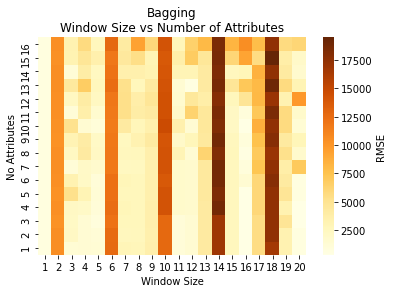

In [30]:
generate_optimisation_heatmap(bagging_df,'Bagging')

100%|██████████| 16/16 [00:44<00:00,  2.81s/it]



The recommended parameter is:
No of top attributes =  1


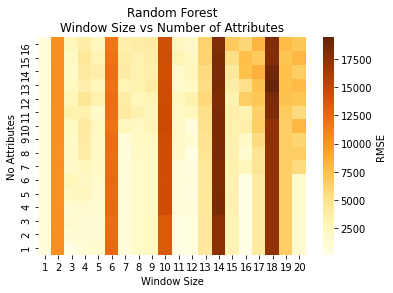

In [13]:
generate_optimisation_heatmap(random_forest_df,'Random Forest')

100%|██████████| 16/16 [00:35<00:00,  2.22s/it]



The recommended parameter is:
No of top attributes =  1


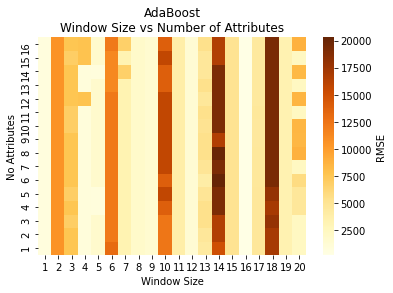

In [14]:
generate_optimisation_heatmap(adaboost_df,'AdaBoost')

100%|██████████| 16/16 [00:13<00:00,  1.22it/s]



The recommended parameter is:
No of top attributes =  1


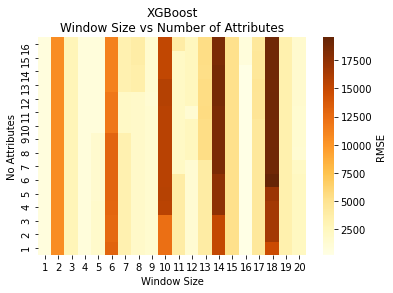

In [15]:
generate_optimisation_heatmap(xgboost_df,'XGBoost')